# CH4-AIR Notebook 
This notebook contains all the methods and the 2 experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle

# Load and prepare data

In [2]:
#read the data into a dataframe
df = pd.read_csv('NewData_flames_data_with_L1_L2_errors_CH4-AIR_with_trimming.txt')



#create an integer representation of the flame-id and add to the data frame
df['flame_key_int'] = df[' flame_key'].mul(10000000).astype(int)

#create an integer to determine if the flame is included by the framework in the manifold creation and reverselookup
#framework_untrimmed_flameids = [0.00115982, 0.00122087, 0.00128512, 0.00135276, 0.00142396, 0.0014989, 0.00157779, 0.00166083, 0.00174825, 0.00184026, 0.00193711, 0.00203907, 0.00214639, 0.00225936, 0.00237827, 0.01]

framework_untrimmed_flameids = ['2.0276547153583627E-4', '2.1343733845877503E-4', '2.2467088258818426E-4', '2.3649566588229923E-4', '2.4894280619189394E-4', '2.6204505914936203E-4', '2.7583690436774953E-4', '2.903546361765785E-4', '3.056364591332405E-4', '3.2172258856130585E-4', '3.3865535638032194E-4', '0.0032353354497370902']


framework_untrimmed_flame_key_ints = [int(float(framework_untrimmed_flameids[i])*10000000) for i in range(len(framework_untrimmed_flameids))]

def isFlame_included(flame_key_int):
    if flame_key_int in framework_untrimmed_flame_key_ints:
        ret_val = 1
    else:
        ret_val = 0
    return ret_val

df['is_flame_included_by_framework'] = df['flame_key_int'].map(lambda x: isFlame_included(x))

df['souener_deciles'] = pd.qcut(df['souener'],10)


### Create PCAs using all the data and add to DF


In [3]:
num_principal_components = 5

pca = PCA(n_components=num_principal_components)

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

X = df[icovariates].values
        
pure_pca_dim_cols = ["PURE_PCA_"+str(i+1) for i in range(num_principal_components)]

pca.fit_transform(X)
        
df_pure_pca = pd.DataFrame(pca.transform(X), columns = pure_pca_dim_cols)
        
df = pd.concat([df,df_pure_pca], axis=1)


### Create Sparse PCA

In [4]:
sparsepca = SparsePCA(n_components=num_principal_components)
      
sparse_pca_dim_cols = ["SPARSE_PCA_"+str(i+1) for i in range(num_principal_components)]

sparsepca.fit_transform(X)
        
df_sparse_pca = pd.DataFrame(sparsepca.transform(X), columns = sparse_pca_dim_cols)
        
df = pd.concat([df,df_sparse_pca], axis=1)

### Create PCAs orthogonal to Zmix and add to DF

In [5]:
zmix_pca_dim_cols = ["Zmix_PCA_"+str(i+1) for i in range(num_principal_components)]

#these are the weights calculated on the basis of molar weight of Hydrogen
wopt = np.array([0.25131806468584, 1.0, 0.0, 0.0, 0.05926499970012948, 0.11189834407236524, 0.03053739933116691, 0.05926499970012948, 0.0, 0.07742283372149472, 0.14371856860332313, 0.14371856860332313, 0.20112514400193687, 1.0, 0.0, 0.0, 0.03473494419333629, 0.06713785861443991, 0.09743596683886535, 0.09743596683886535, 0.12582790137651187, 0.04027033873046593, 0.07742283372149472, 0.11180607885607882, 0.14371856860332313, 0.17341738612784788, 0.20112514400193687, 0.024566681794273966, 0.04795526192839207, 0.04795526192839207, 0.0, 0.06713048065088474, 0.12581494366075874, 0.17755300484072126, 0.034730994502665966, 0.0, 0.0, 0.0, 0.03249947443158002, 0.0, 0.0372961080230628, 0.07191024382448291, 0.024564706019978535, 0.023426986426879046, 0.023426986426879046, 0.023426986426879046, 0.0, 0.16374935944566987, 0.18286442054789118, 0.07024850027715426, 0.09152158240065958, 0.0, 0.0] , dtype=float)

'''
Zmix = wopt * Xi --> Zmix += mixFracMassCoeff[s] * Yi[s] in the following code and then it is normalized
Z_f = 0.25131806468584
Z_ox = 0.0
(Zmix - Z_ox) / (Z_f - Z_ox)

public double calc(double[] Yi) {
		double Zmix = 0.;
		for (int s = 0; s < species.length; s++) {
			Zmix += mixFracMassCoeff[s] * Yi[s];
		}
		return (Zmix - Z_ox) / (Z_f - Z_ox);
	}
'''

w = wopt[:,np.newaxis]

# center the data
Xcenter = X - np.mean(X)

A = np.cov(X.T)

# calculate A - ww^TA
L = A - np.dot(np.dot(w,w.T),A)

# get the first eigen vector
values,vectors = np.linalg.eig(L)

vectors = np.real(vectors)

values = np.real(values)

df_zmix_pca = pd.DataFrame()

'''
To reproduce Zmix the actual formula should be 

df_zmix_pca[zmix_pca_dim_cols[0]] = X.dot(wopt)/0.25131806468584

instead of

df_zmix_pca[zmix_pca_dim_cols[0]] = Xcenter.dot(wopt)
'''

df_zmix_pca[zmix_pca_dim_cols[0]] = X.dot(wopt)/0.25131806468584

for i in range(len(zmix_pca_dim_cols)-1):
    df_zmix_pca[zmix_pca_dim_cols[i+1]] = Xcenter.dot(vectors.T[i])
        
df = pd.concat([df,df_zmix_pca], axis=1)

In [6]:
df[sparse_pca_dim_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SPARSE_PCA_1,16439.0,2.053092e-17,0.286286,-0.750127,-0.195033,0.150253,0.233631,0.233655
SPARSE_PCA_2,16439.0,-1.566833e-17,0.225457,-0.129794,-0.129187,-0.119775,0.014577,0.842079
SPARSE_PCA_3,16439.0,1.685697e-17,0.123741,-0.219599,-0.104966,0.005778,0.099924,0.256044
SPARSE_PCA_4,16439.0,7.023736e-19,0.104072,-0.141973,-0.092128,-0.016216,0.080874,0.231253
SPARSE_PCA_5,16439.0,-1.080575e-19,0.063361,-0.142204,-0.041495,0.009795,0.048431,0.107390


In [7]:
df[pure_pca_dim_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PURE_PCA_1,16439.0,-1.058963e-17,0.325106,-0.490897,-0.237622,-0.114789,0.235187,0.791945
PURE_PCA_2,16439.0,-2.334041e-17,0.238645,-0.317749,-0.189767,-0.045990,0.133304,0.784339
PURE_PCA_3,16439.0,5.267802e-18,0.060421,-0.151624,-0.025273,0.003243,0.035351,0.181623
PURE_PCA_4,16439.0,-9.205146e-18,0.017965,-0.041385,-0.011442,-0.001985,0.007269,0.058252
PURE_PCA_5,16439.0,-2.225309e-18,0.012196,-0.026776,-0.008929,-0.000455,0.008275,0.028624


In [8]:
df[zmix_pca_dim_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Zmix_PCA_1,16439.0,0.430011,0.260305,0.004543,0.212671,0.396430,0.631240,0.995403
Zmix_PCA_2,16439.0,0.072002,0.309451,-0.387347,-0.153352,-0.041850,0.294727,0.831019
Zmix_PCA_3,16439.0,0.047210,0.238312,-0.740447,-0.083354,0.093506,0.235925,0.362873
Zmix_PCA_4,16439.0,0.077555,0.059722,-0.072789,0.052942,0.080633,0.112486,0.256762
Zmix_PCA_5,16439.0,-0.081254,0.017963,-0.139508,-0.088494,-0.079298,-0.069824,-0.039882


In [9]:
df[['Zmix']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Zmix,16439.0,0.430011,0.260305,0.004543,0.212671,0.39643,0.63124,0.995403


In [10]:
#Comparing the 'X' matrix column arrangement for the Constrained PCA formulation
#icovariates
#[CH4, H, O, O2, OH, H2O, HO2, H2O2, C, CH, CH2, CH2(S), CH3, H2, CO, CO2, HCO, CH2O, CH2OH, CH3O, CH3OH, C2H, C2H2, C2H3, C2H4, C2H5, C2H6, HCCO, CH2CO, HCCOH, N, NH, NH2, NH3, NNH, NO, NO2, N2O, HNO, CN, HCN, H2CN, HCNN, HCNO, HOCN, HNCO, NCO, C3H7, C3H8, CH2CHO, CH3CHO, N2, AR]
#df.head()['Zmix']
#X[3].dot(wopt)/0.25131806468584
#Zmix matches with the calculation

In [11]:
'''
import pandas as pd
import numpy as np
import sklearn

dates=['April-10', 'April-11', 'April-12', 'April-13']
fruits=['Apple', 'Papaya', 'Banana', 'Mango']
prices=[3, 1, 2, 4]



tdf = pd.DataFrame({'Date':dates ,
                   'Fruit':fruits ,
                   'Price': prices})

print('Before')
print(tdf)

tdf_shuffled=sklearn.utils.shuffle(tdf,random_state=0)
print(tdf_shuffled)
print('After')
print(tdf)

'''

"\nimport pandas as pd\nimport numpy as np\nimport sklearn\n\ndates=['April-10', 'April-11', 'April-12', 'April-13']\nfruits=['Apple', 'Papaya', 'Banana', 'Mango']\nprices=[3, 1, 2, 4]\n\n\n\ntdf = pd.DataFrame({'Date':dates ,\n                   'Fruit':fruits ,\n                   'Price': prices})\n\nprint('Before')\nprint(tdf)\n\ntdf_shuffled=sklearn.utils.shuffle(tdf,random_state=0)\nprint(tdf_shuffled)\nprint('After')\nprint(tdf)\n\n"

In [12]:
framework_included_flames_int = df[df['is_flame_included_by_framework'] == 1]['flame_key_int'].unique()

framework_excluded_flames_int = df[df['is_flame_included_by_framework'] == 0]['flame_key_int'].unique()

all_flames_int = df['flame_key_int'].unique()


In [13]:
class DataManager:
    def __init__(self, df_totalData):
        self.df = df_totalData
        self.outputScaler = None
        self.inputScaler = None
        self.zmixScaler = None
        self.df_training = None
        self.df_testing = None
        self.X_train = None
        self.X_test = None
        self.zmix_train = None
        self.zmix_test = None
        self.Y_train = None
        self.Y_test = None
        
        return

    def _createTrainTestDfs(self,method):

        if(method == "randomequaltraintestsplit"):
            df_shuffled= shuffle(self.df, random_state=0)
            self.df_training = df_shuffled[::2]
            self.df_testing = df_shuffled[1::2]

        else:
            training_flames_int = []


            testing_flames_int = []

            if(method == "frameworkincludedexcludedequalsplit"):

                for x in framework_included_flames_int:
                    training_flames_int.append(x)

                for x in framework_excluded_flames_int[::2]:
                    training_flames_int.append(x)

                for x in framework_included_flames_int:
                    testing_flames_int.append(x)

                for x in framework_excluded_flames_int[1::2]:
                    testing_flames_int.append(x)

            elif(method == "frameworkincludedtrainexcludedtest"):
                for x in framework_included_flames_int:
                    training_flames_int.append(x)

                for x in framework_excluded_flames_int:
                    testing_flames_int.append(x)

            elif(method == "frameworkincludedtrainexcludedandincludedtest"):
                for x in framework_included_flames_int:
                    training_flames_int.append(x)

                for x in framework_included_flames_int:
                    testing_flames_int.append(x)

                for x in framework_excluded_flames_int:
                    testing_flames_int.append(x)

            else:
                for x in all_flames_int:
                    training_flames_int.append(x)
                    testing_flames_int.append(x)

            self.df_training = self.df[self.df['flame_key_int'].isin(training_flames_int)]

            self.df_testing = self.df[self.df['flame_key_int'].isin(testing_flames_int)]

        return


    def _createTrainTestData(self,method,numCpvComponents):

        method_parts = method.split('_')

        self._createTrainTestDfs(method_parts[1])

        input_data_cols = []
        
        output_data_cols = ["souener"]        

        if method_parts[0] == "ZmixCpv":
            input_data_cols = ["Zmix","Cpv"]
        elif method_parts[0] == "ZmixPCA":
            input_data_cols = zmix_pca_dim_cols[0:numCpvComponents] 
        elif method_parts[0] == "SparsePCA":
            input_data_cols = sparse_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "PurePCA":
            input_data_cols = pure_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "ZmixAllSpecies":    
            input_data_cols = ['Zmix'] + icovariates
        else:
            input_data_cols = icovariates

        self.X_train = self.df_training [input_data_cols].values
        self.X_test = self.df_testing [input_data_cols].values  
        self.zmix_train = self.df_training ['Zmix'].values
        self.zmix_test = self.df_testing ['Zmix'].values
        self.Y_train = self.df_training [output_data_cols].values
        self.Y_test = self.df_testing [output_data_cols].values
        
        return
    
    def _setInputOutputScalers(self, ipscaler, opscaler):
        if ipscaler == "MinMaxScaler":
            self.inputScaler = MinMaxScaler()
            self.zmixScaler = MinMaxScaler()
        elif ipscaler == "QuantileTransformer":
            self.inputScaler = QuantileTransformer()
            self.zmixScaler = QuantileTransformer()
        else:
            self.inputScaler = None
            self.zmixScaler = None
        if opscaler == "MinMaxScaler":
            self.outputScaler = MinMaxScaler()
        elif opscaler == "QuantileTransformer":
            self.outputScaler = QuantileTransformer()
        else:
            self.outputScaler = None
            
    def createTrainTestData(self,dataSetMethod,numCpvComponents, ipscaler, opscaler):
        self._createTrainTestData(dataSetMethod,numCpvComponents)
        
        self._setInputOutputScalers(ipscaler, opscaler)
        
        if self.inputScaler is not None:
            self.X_train = self.inputScaler.fit_transform(self.X_train)
            self.X_test = self.inputScaler.fit_transform(self.X_test)
            
        if self.outputScaler is not None:
            self.Y_train = self.outputScaler.fit_transform(self.Y_train.reshape(self.Y_train.shape[0], 1))
            self.Y_test = self.outputScaler.fit_transform(self.Y_test.reshape(self.Y_test.shape[0], 1))
            self.Y_train = self.Y_train.flatten()
            self.Y_test = self.Y_train.flatten()

0.0002220446049250313

In [47]:
class CustomGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=150,max_fun=50, gtol=1e-05, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol
        self._max_fun = max_fun

    #ftol = 1000000000000.0 (factr) * np.finfo(float).eps
    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter,'maxfun':self._max_fun,'gtol': self._gtol,'ftol':0.0002220446049250313})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min



def getGPModel(kernel="Matern"):
    if kernel == "Matern_RationalQuadratic":

        # medium term irregularities
        k1 = 0.5* Matern(length_scale=2, nu=3/2)
        k2 = 0.5* RationalQuadratic(length_scale=1.0, alpha=1.0)

        '''
        k4 = 0.1**2 * RBF(length_scale=0.1) \+ WhiteKernel(noise_level=0.1**2,
                      noise_level_bounds=(1e-3, np.inf))  # noise terms
        '''
        kernel = k1 + k2

    elif kernel == "RationalQuadratic":

        # medium term irregularities
        kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)    

    else:
        kernel = Matern(length_scale=2, nu=3/2)

    return CustomGPR(kernel=kernel) 


In [48]:
dm = DataManager(df)

In [49]:
experimentTrackingFields = ['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime']

df_experimentTracker = pd.DataFrame(columns=experimentTrackingFields)

import os#must import this library

if os.path.exists('results.csv'):
        os.remove('results.csv') #this deletes the file
else:
        print("The results.csv file does not exist")

resultsFile = open('results.csv', 'w')

printStr = "\t"

printStr = printStr.join(experimentTrackingFields)


resultsFile.write(printStr)

resultsFile.write("\n")


1

In [50]:
class ExperimentExecutor:
    def __init__(self):
        self.dm = None
        self.modelType = None
        self.model = None
        self.df_experimentTracker = None
        self.fit_time = None
        self.pred_time = None
        self.err = None
     
    def setModel(self,model):
        self.model = model
        
    def executeExperiments(self,dataManager, modelType, df_experimentTracker):
        self.dm = dataManager
        self.modelType = modelType
        self.df_experimentTracker = df_experimentTracker
        
        #Experiments  
        
        #dataTypes = ["randomequaltraintestsplit","frameworkincludedtrainexcludedtest"]
        dataTypes = ["frameworkincludedtrainexcludedtest"]
        
        #inputTypes = ["ZmixCpv","ZmixPCA","SparsePCA","PurePCA","ZmixAllSpecies","AllSpecies"]
        inputTypes = ["ZmixCpv"]
        
        for dataType in dataTypes:
            
            for inputType in inputTypes:
                #ZmixCpv_randomequaltraintestsplit
                dataSetMethod = inputType + '_' + dataType
                        
                if inputType.find('Zmix') != -1:
                    ZmixPresent = 'Y'
                else:
                    ZmixPresent = 'N'
                    
                if inputType.find('PCA') != -1:
                    
                    noOfCpvs = [item for item in range(1, 6)]
                    
                    for noOfCpv in noOfCpvs:
                        #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
                        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)
                        
                        self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)
                                                
                        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.err[2]),str(self.err[0]),str(self.err[3]),str(self.err[1]),str(self.err[5]),str(self.fit_time),str(self.pred_time)]

                        self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

                        printStr = "self.modelType: "+ self.modelType+ "dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

                        print(printStr)

                        printStr = "\t"

                        printStr = printStr.join(experimentResults)

                        resultsFile.write(printStr)

                        resultsFile.write("\n")
                        
                        
                else:
                   
                    if inputType.find('ZmixCpv') != -1:
                        noOfCpv = 1
                    else:
                        noOfCpv = 53
                        
                    #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
                    self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)

                    self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)    

                    experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.err[2]),str(self.err[0]),str(self.err[3]),str(self.err[1]),str(self.err[5]),str(self.fit_time),str(self.pred_time)]
                        
                    self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

                    printStr = "self.modelType: "+ self.modelType+ "dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

                    print(printStr)

                    printStr = "\t"

                    printStr = printStr.join(experimentResults)

                    resultsFile.write(printStr)

                    resultsFile.write("\n")
        
    def computeError (self,Y_pred, Y_test):
        evaluation_df_1 = pd.DataFrame()

        evaluation_df_1['souener'] = Y_test.flatten()

        evaluation_df_1['souener_pred'] = Y_pred.flatten()

        evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

        evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']

        evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 

        TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

        TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

        MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

        MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()

        NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

        MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

        return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

            
    def printError (self,err):
        TotalAbsoluteError = err[0]

        TotalSquaredError = err[1]

        MeanAbsoluteError = err[2]

        MeanSquaredError = err[3]

        MeanPercentageError = err[4]

        NumPoints = err[5]
        
        print ('Total Absolute Error: ', TotalAbsoluteError)
        print ('Mean Absolute Error: ', MeanAbsoluteError)
        print ('Mean Percentage Error: ', MeanPercentageError)
        print ('Total Squared Error: ', TotalSquaredError)
        print ('Mean Squared Error: ', MeanSquaredError)
        print ('Number of Points: ', NumPoints)

    def computeAndPrintError(self,Y_pred, Y_test):    
        self.err = computeError (Y_pred, Y_test)
        printError (err)
        logError(err)
        return err    
        
        
        
    def fitModelAndCalcErr(self,X_train, Y_train, X_test, Y_test):

        t = time.process_time()

        self.model.fit(X_train, Y_train)

        self.fit_time = time.process_time() - t

        t = time.process_time()

        Y_pred = self.model.predict(X_test, return_std=False)

        self.pred_time = time.process_time() - t
        
        #computeAndPrintError(Y_pred, Y_test)

        self.err = self.computeError (Y_pred, Y_test)
        
        return 

In [51]:
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("Matern"))
expExectr.executeExperiments(dm, "GP_Matern", df_experimentTracker)

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


self.modelType: GP_MaterndataType: frameworkincludedtrainexcludedtest inputType:ZmixCpv noOfCpv:1 ZmixPresent:Y MAE:5992605095.365914


In [ ]:
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("Matern_RationalQuadratic"))
expExectr.executeExperiments(dm, "GP_Matern_RationalQuadratic", df_experimentTracker)

In [ ]:
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("RationalQuadratic"))
expExectr.executeExperiments(dm, "GP_RationalQuadratic", df_experimentTracker)

In [ ]:
df_experimentTracker.head()

In [46]:
df_experimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments.csv', sep='\t',encoding='utf-8', index=False)

#!!!!!!! Very Important !!!!!!
resultsFile.close()

## DNN Method Support Functions

In [11]:
from numpy import genfromtxt
def get_neighborhood(neighborhooddisttype,datasettype):
    #neighbors_cosine_dataset_test_ZmixPCA_frameworkincludedexcludedequalsplit
    train_filename = "neighbors_" + neighborhooddisttype + "_dataset_train_" + datasettype + ".csv"
    test_filename = "neighbors_" + neighborhooddisttype + "_dataset_test_" + datasettype + ".csv"
    neighbors_dataset_train = genfromtxt(train_filename, delimiter=',')
    neighbors_dataset_test = genfromtxt(test_filename, delimiter=',')
    return neighbors_dataset_train,neighbors_dataset_test

def computeAndSaveNeighborhood():        
    # Train distance function
    neighbors_dataset_train = list()

    for i in range(X_train.shape[0]):
        neighbors_dataset_train.append(get_neighbors(X_train, Y_train, X_train[i], num_neighbors,"manhattan"))

    # Test distance function
    neighbors_dataset_test = list()

    for i in range(X_test.shape[0]):
        neighbors_dataset_test.append(get_neighbors(X_train, Y_train, X_test[i], num_neighbors,"manhattan"))

    neighbors_dataset_train = np.asarray(neighbors_dataset_train)
    neighbors_dataset_test = np.asarray(neighbors_dataset_test)
    from numpy import savetxt
    savetxt('neighbors_dataset_train_ZmixPCA.csv', neighbors_dataset_train, delimiter=',')
    savetxt('neighbors_dataset_test_ZmixPCA.csv', neighbors_dataset_test, delimiter=',')

In [12]:
# Example of getting neighbors for an instance
from math import sqrt
from scipy import spatial

num_neighbors = 48

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# calculate the Euclidean distance between two vectors
def weighted_euclidean_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j*(row1[i] - row2[i])**2
        j = j -1
    return sqrt(distance)

# calculate the Manhattan distance between two vectors
def weighted_manhattan_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j* abs(row1[i] - row2[i])
        j = j -1
    return distance

# calculate the Manhattan distance between two vectors
def manhattan_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += abs(row1[i] - row2[i])
    return distance

def cosine_distance(row1, row2):
    distance = 0.0
    distance = 1 - spatial.distance.cosine(row1, row2)
    return distance


# Locate the most similar neighbors
def get_neighbors(train, train_label, test_row, num_neighbors,dist_type):
    
    distances = list()
    
    i = 0
    
    for train_row in train:
        
        if dist_type == "cosine":
            dist = cosine_distance(test_row, train_row)
        elif dist_type == "manhattan":
            dist = manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_manhattan":
            dist = weighted_manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_euclidean":
            #euclidean":
            dist = weighted_euclidean_distance(test_row, train_row)
        else:
            #euclidean":
            dist = euclidean_distance(test_row, train_row)
        
        distances.append((train_label[i],train_row, dist))
        
        i = i + 1
    
    distances.sort(key=lambda tup: tup[2])
   
    neighbors = list()
    
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    
    neighbors = np.asarray(neighbors).flatten()
    
    return neighbors

In [13]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 
   
    return evaluation_df_1['res'].values


In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Souener]')
    plt.legend()
    plt.grid(True)
    
   

# Experiment I
## Training on all Untrimed Flames
### Zmix, Cpv

In [15]:
#ZmixPCA_frameworkincludedtrainexcludedtest
#ZmixPCA_frameworkincludedexcludedequalsplit
X_train,Y_train,X_test, Y_test  = getTrainTestData("ZmixCpv_frameworkincludedtrainexcludedtest")


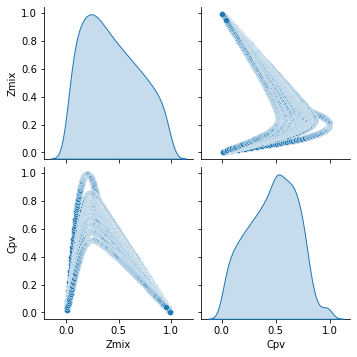

In [16]:
#X_train_df = pd.DataFrame(X_train ,columns = zmix_pca_dim_cols)
X_train_df = pd.DataFrame(X_train ,columns = ["Zmix","Cpv"])
sns.pairplot(X_train_df, diag_kind='kde')

### GP Matern Kernel

In [17]:
print ('Zmix+PCA(2 components) trained using Framework Included Flames and Test on Flames Excluded by Framework\n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(2 components) trained using Framework Included Flames and Test on Flames Excluded by Framework



C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\sklearn\gaussian_process\kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


GP Time for Initial Fit:  23.0625
GP Time for Prediction:  3.6875
Total Absolute Error:  77046923711119.56
Mean Absolute Error:  5992605095.365914
Mean Percentage Error:  0.9781810518642399
Total Squared Error:  2.8175944104747773e+24
Mean Squared Error:  2.191486669110039e+20
Number of Points:  12857


In [26]:
errorLst = {}

In [19]:
errorLst['Zmix+PCA(2 Components) GP'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

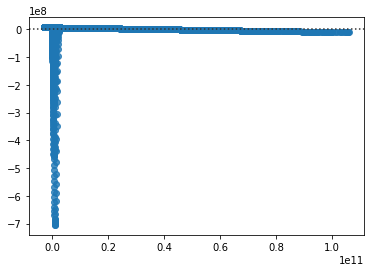

In [20]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNN 

In [15]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)

width = 512
halfwidth = 128
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(width, activation='relu'),
      layers.Dense(width, activation='relu'),
      layers.Dense(halfwidth, activation='relu'),
      layers.Dense(halfwidth, activation='relu'),  
      layers.Dense(width, activation='relu'),
      layers.Dense(width, activation='relu'),
      layers.Dense(1)
    ])
        
    
    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    #model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [22]:
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2

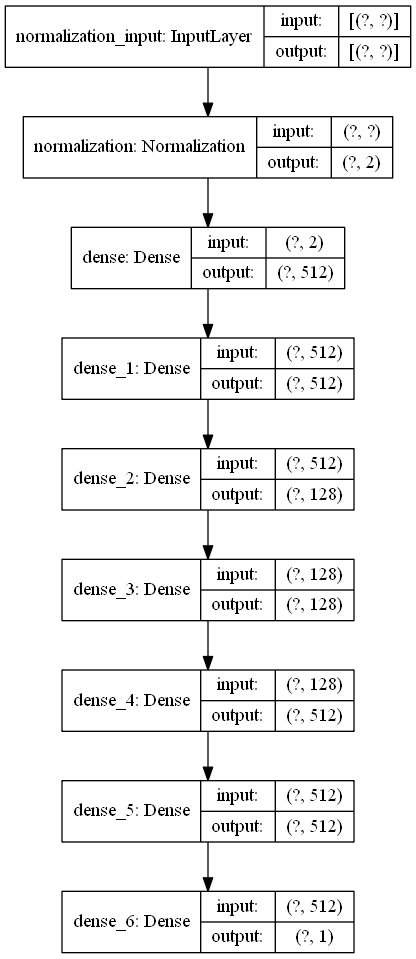

In [23]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [24]:
%%time
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

Wall time: 1min 12s


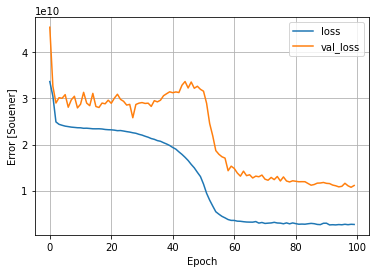

In [25]:
plot_loss(history)

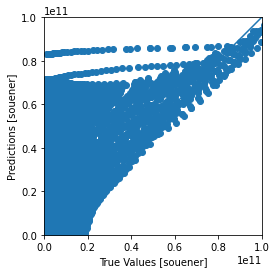

In [26]:
Y_pred = model.predict(X_test)

a = plt.axes(aspect='equal')
plt.scatter(Y_test.flatten(), Y_pred.flatten())
plt.xlabel('True Values [souener]')
plt.ylabel('Predictions [souener]')
lims = [0, 1e11]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [27]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  109649335258677.45
Mean Absolute Error:  8528376390.968146
Mean Percentage Error:  121.61419216343373
Total Squared Error:  3.255351412454282e+24
Mean Squared Error:  2.5319681204435576e+20
Number of Points:  12857


In [28]:
errorLst['Zmix+PCA(2 Components) DNN'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

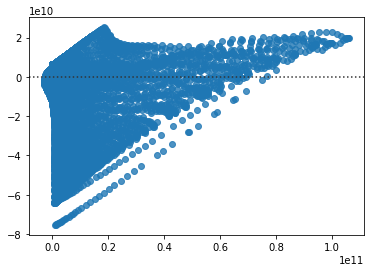

In [29]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Scrambled Data 

In [58]:
X = df[["Zmix","Cpv"]].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_shuffled, Y_shuffled = shuffle(X, Y, random_state=0)
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]



### Matern GP 

In [59]:
print ('Zmix+PCA(2 components) trained using 50% Test Flames \n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(2 components) trained using 50% Test Flames 

GP Time for Initial Fit:  21886.078125
GP Time for Prediction:  3.015625
Total Absolute Error:  80020382413510.52
Mean Absolute Error:  9736024140.833498
Mean Percentage Error:  4.501514522318314
Total Squared Error:  5.86881983581071e+24
Mean Squared Error:  7.140552178866905e+20
Number of Points:  8219


In [ ]:
errorLst['Zmix+PCA(2 Components) GP 50% Random'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

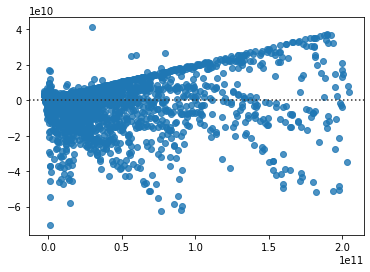

In [60]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNNN

In [20]:
%%time
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2

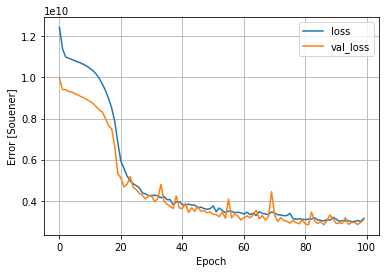

In [21]:
plot_loss(history)

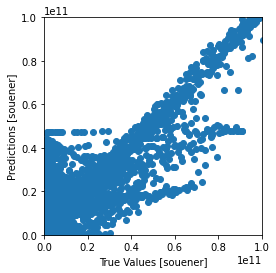

In [23]:
Y_pred = model.predict(X_test)

a = plt.axes(aspect='equal')
plt.scatter(Y_test.flatten(), Y_pred.flatten())
plt.xlabel('True Values [souener]')
plt.ylabel('Predictions [souener]')
lims = [0, 1e11]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [24]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  24440832414393.043
Mean Absolute Error:  2973699040.5636992
Mean Percentage Error:  5.26128952564595
Total Squared Error:  4.248442610890747e+23
Mean Squared Error:  5.169050506011373e+19
Number of Points:  8219


In [27]:
errorLst['Zmix+PCA(2 Components) DNN 50% Random'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

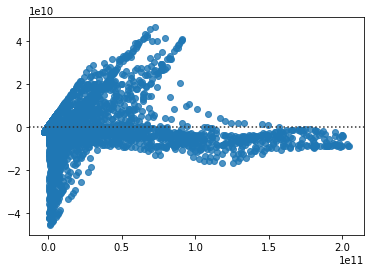

In [28]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

# Experiment II
## Training on all Untrimed Flames
### Zmix, 4 PCA

In [44]:
#ZmixPCA_frameworkincludedtrainexcludedtest
#ZmixPCA_frameworkincludedexcludedequalsplit
X_train,Y_train,X_test, Y_test  = getTrainTestData("ZmixPCA_frameworkincludedtrainexcludedtest")

### Matern GP

In [30]:
print ('Zmix+PCA(4 components) trained using Framework Included Flames and Test on Flames Excluded by Framework\n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(4 components) trained using Framework Included Flames and Test on Flames Excluded by Framework



C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\ipykernel_launcher.py:10: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  # Remove the CWD from sys.path while we load stuff.


GP Time for Initial Fit:  218.09375
GP Time for Prediction:  1.765625
Total Absolute Error:  34070245412856.35
Mean Absolute Error:  2649937420.3046083
Mean Percentage Error:  4.459035375224145
Total Squared Error:  3.789950971472544e+23
Mean Squared Error:  2.9477723975052845e+19
Number of Points:  12857


In [31]:
errorLst['Zmix+PCA(4 Components) GP'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

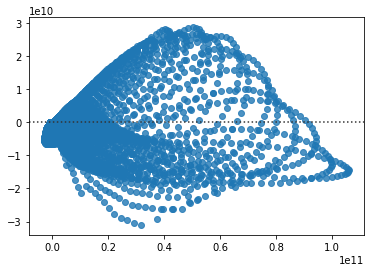

In [32]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNN 

In [45]:
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_14 (Dense)             (None, 512)               3072      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_19 (Dense)             (None, 512)              

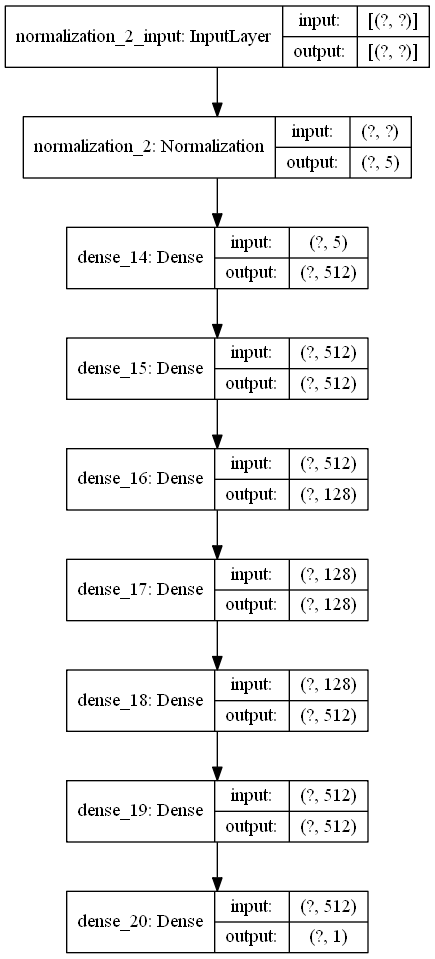

In [46]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)


In [47]:
%%time
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

Wall time: 59.4 s


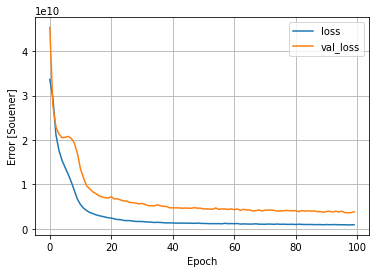

In [48]:
plot_loss(history)

In [49]:
Y_pred = model.predict(X_test)
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  34696176734201.55
Mean Absolute Error:  2698621508.454659
Mean Percentage Error:  2.365783531302725
Total Squared Error:  5.4109150520973305e+23
Mean Squared Error:  4.20853624647844e+19
Number of Points:  12857


In [37]:
errorLst['Zmix+PCA(4 Components) DNN'] = err

NameError: name 'errorLst' is not defined

<AxesSubplot:>

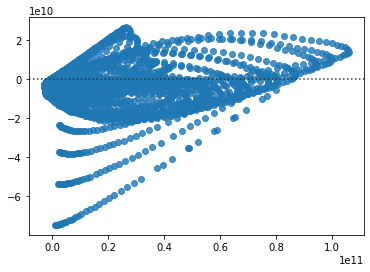

In [50]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Scrambled Data 

### Matern GP 

In [51]:
X = df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_shuffled, Y_shuffled = shuffle(X, Y, random_state=0)
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]



In [41]:
print ('Zmix+PCA(4 components) trained using 50% data\n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(4 components) trained using 50% data

GP Time for Initial Fit:  5320.625
GP Time for Prediction:  2.375
Total Absolute Error:  3973061426515.995
Mean Absolute Error:  483399613.88441354
Mean Percentage Error:  0.49245306615795975
Total Squared Error:  6.479068521889638e+22
Mean Squared Error:  7.883037500778243e+18
Number of Points:  8219


In [42]:
errorLst['Zmix+PCA(4 Components) GP 50% data'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

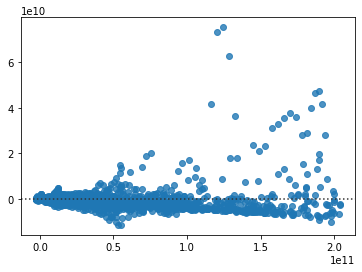

In [43]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNN 

In [52]:
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_21 (Dense)             (None, 512)               3072      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_26 (Dense)             (None, 512)              

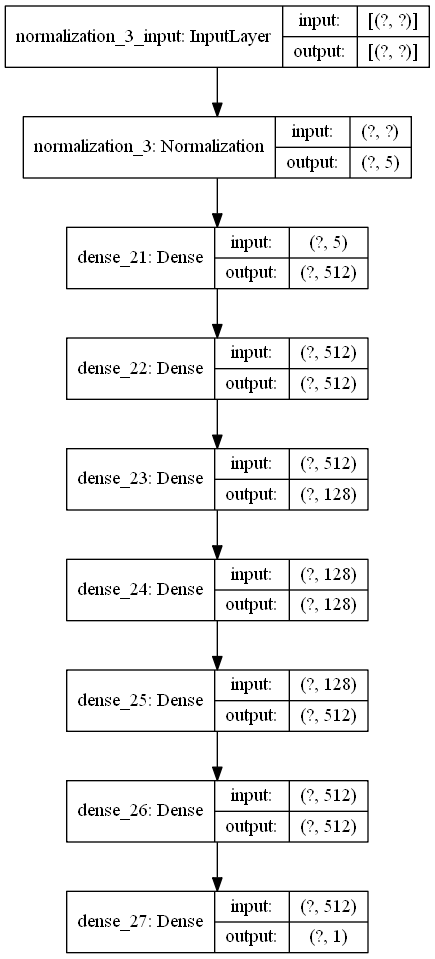

In [53]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [54]:
%%time
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

Wall time: 2min 40s


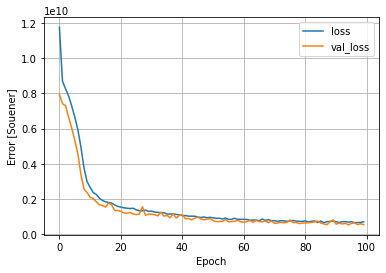

In [55]:
plot_loss(history)

In [56]:
Y_pred = model.predict(X_test)
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  5074892931279.571
Mean Absolute Error:  617458684.9105209
Mean Percentage Error:  4.007261541735772
Total Squared Error:  4.875432858102316e+22
Mean Squared Error:  5.931905168636471e+18
Number of Points:  8219


In [49]:
errorLst['Zmix+PCA(4 Components) DNN'] = err

<AxesSubplot:>

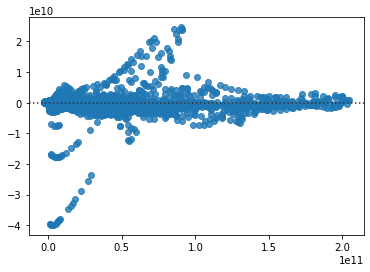

In [57]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### All Species DNN

In [16]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

In [29]:
Y_test

array([[5.58632012e+09],
       [4.02360148e+09],
       [5.81072585e+08],
       ...,
       [7.87871399e+10],
       [3.31228134e+08],
       [1.02734466e+10]])

In [25]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()
# fit and transform in one step

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

In [44]:
normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [33]:
normalized_souener_train.shape

(8220,)

In [34]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
species_inputs = keras.Input(shape=(53,), name="species_input")

linear_reduced_dims = layers.Dense(5, name="linear_layer")(species_inputs)

x = layers.Dense(32, activation="relu")(linear_reduced_dims)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

physics_pred = layers.Dense(5, name="physics")(linear_reduced_dims)

model = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred, physics_pred],
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_layer (Dense)            (None, 5)            270         species_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         linear_layer[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        dense[0][0]                      
_______________________________________________________________________________________

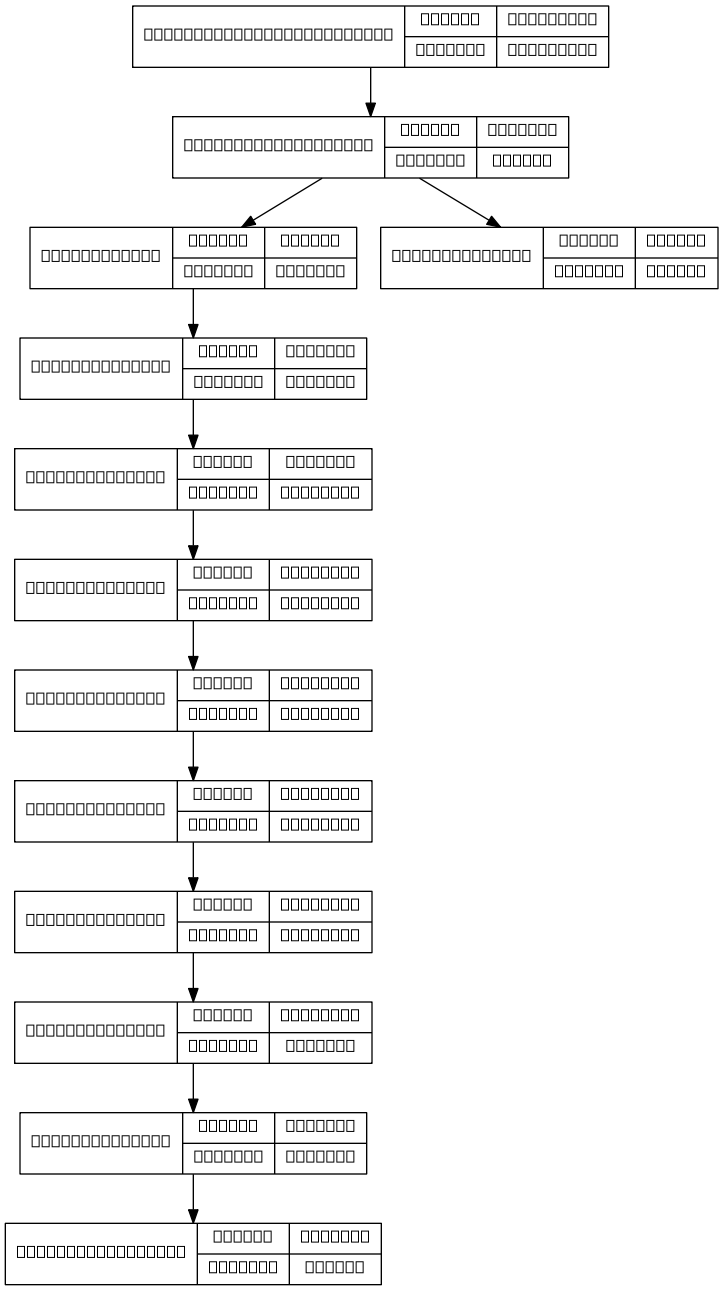

In [36]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [78]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss={
        "physics": keras.losses.MeanAbsoluteError(),
        "prediction": keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[2.0, 0.2],
)

In [87]:
%%time
#batch_size=100,
history = model.fit(normalized_species_train, 
                    {
                        "physics": normalized_zmixpca_train,
                        "prediction":normalized_souener_train#Y_train
                    },
                    validation_split=0.2,
                    verbose=0, 
                    epochs=100
                   )

Wall time: 55 s


In [88]:
def plot_loss_physics_and_regression(history):
    '''
    fig, axs = plt.subplots(1, 2, figsize=(6,6))
    plt.subplots_adjust(wspace=.75)
    axs[0].plot(history.history['prediction_loss'], label='loss')
    axs[0].plot(history.history['val_prediction_loss'], label='val_loss')
    axs[0].set_title('Souener Prediction Loss')
    axs[0].set(xlabel='Epoch', ylabel='Souener Error')
    axs[0].legend()
    
    axs[1].plot(history.history['physics_loss'], label='loss')
    axs[1].plot(history.history['val_physics_loss'], label='val_loss')
    axs[1].set_title('Physics Loss')
    axs[1].set(xlabel='Epoch', ylabel='Physics Error')
    axs[1].legend()
    '''
    
    
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.plot(history.history['prediction_loss'], label='loss')
    ax.plot(history.history['val_prediction_loss'], label='val_loss')
    ax.set_title('Souener Prediction Loss')
    ax.set(xlabel='Epoch', ylabel='Souener Error')
    ax.legend()

    ax2.plot(history.history['physics_loss'], label='loss')
    ax2.plot(history.history['val_physics_loss'], label='val_loss')
    ax2.set_title('Physics Loss')
    ax2.set(xlabel='Epoch', ylabel='Physics Error')
    ax2.legend()
        

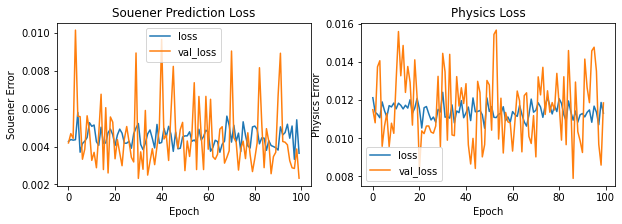

In [89]:
plot_loss_physics_and_regression(history)

In [90]:
predictions = model.predict(normalized_species_test)

normalized_souener_pred = predictions[0]

normalized_zmixpca_pred = predictions[1]

In [91]:
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [92]:
Y_pred = Y_pred.flatten()

In [93]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  4075696778120.0723
Mean Absolute Error:  495887185.56029594
Mean Percentage Error:  11.566193482823351
Total Squared Error:  1.2845184238119073e+22
Mean Squared Error:  1.5628646110377265e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

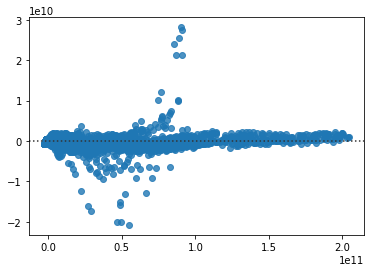

In [94]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

In [ ]:
Total Absolute Error:  6563454066133.884
Mean Absolute Error:  798570880.4153649

In [ ]:
Total Absolute Error:  4075696778120.0723
Mean Absolute Error:  495887185.56029594

In [95]:
model.save("pcdnn_paper_1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pcdnn_paper_1\assets
